# Visualisation on prediction result

## Merchant risk level

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
merchant_risk_level = pd.read_csv('../data/curated/merchant/merchant_risk_level.csv')

In [3]:
merchant_risk_level

,merchant_abn,risk_level
0,10023283211,1.0
1,10142254217,1.0
2,10187291046,1.0
3,10192359162,1.0
4,10206519221,1.0
...,...,...
3677,99938978285,1.0
3678,99974311662,1.0
3679,99976658299,1.0
3680,99987905597,1.0


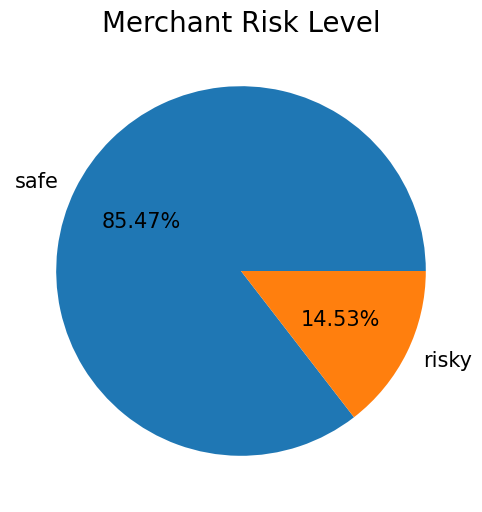

In [4]:
# count frequency
risk_counts = merchant_risk_level['risk_level'].value_counts()
risk_counts.index = ['safe', 'risky']

# draw pie chart
risk_counts.plot(kind='pie', autopct='%.2f%%', figsize=(6, 6), fontsize=15)
plt.title('Merchant Risk Level', fontsize=20)
plt.ylabel('')
plt.show()

In [5]:
risk_counts

safe     3147
risky     535
Name: risk_level, dtype: int64

## Merchant area based fraud distribution

In [6]:
merchant_segment = pd.read_csv('../data/curated/merchant/merchant_clean_segment.csv')
merchant_segment

,merchant_abn,name,goods,revenue_level,take_rate,first_word,segment
0,10023283211,Felis Limited,furniture home furnishing equipment shop manuf...,e,0.18,furniture,lifestyle
1,10142254217,Arcu Ac Orci Corporation,cable satellite pay television radio service,b,4.22,telecom,technical
2,10165489824,Nunc Sed Company,jewelry watch clock silverware shop,b,4.40,jewelry,accessory
3,10187291046,Ultricies Dignissim Lacus Foundation,watch clock jewelry repair shop,b,3.29,jewelry,accessory
4,10192359162,Enim Condimentum PC,music shop musical instrument piano sheet music,a,6.33,music,entertainment
...,...,...,...,...,...,...,...
4021,99938978285,Elit Dictum Eu Ltd,optician optical good eyeglass,b,4.50,optician,specialty
4022,99974311662,Mollis LLP,book periodical newspaper,b,3.17,book,entertainment
4023,99976658299,Sociosqu Corp.,shoe shop,a,6.57,shoe,accessory
4024,99987905597,Commodo Hendrerit LLC,motor vehicle supply new part,a,6.82,motor,specialty


In [7]:
# merge merchant_risk_level and merchant_segment and keep only abn, risk_level and segment
merchant_risk_by_segment = pd.merge(merchant_risk_level, merchant_segment, on='merchant_abn')[['merchant_abn', 'risk_level', 'segment']]
merchant_risk_by_segment

,merchant_abn,risk_level,segment
0,10023283211,1.0,lifestyle
1,10142254217,1.0,technical
2,10187291046,1.0,accessory
3,10192359162,1.0,entertainment
4,10206519221,1.0,lifestyle
...,...,...,...
3677,99938978285,1.0,specialty
3678,99974311662,1.0,entertainment
3679,99976658299,1.0,accessory
3680,99987905597,1.0,specialty


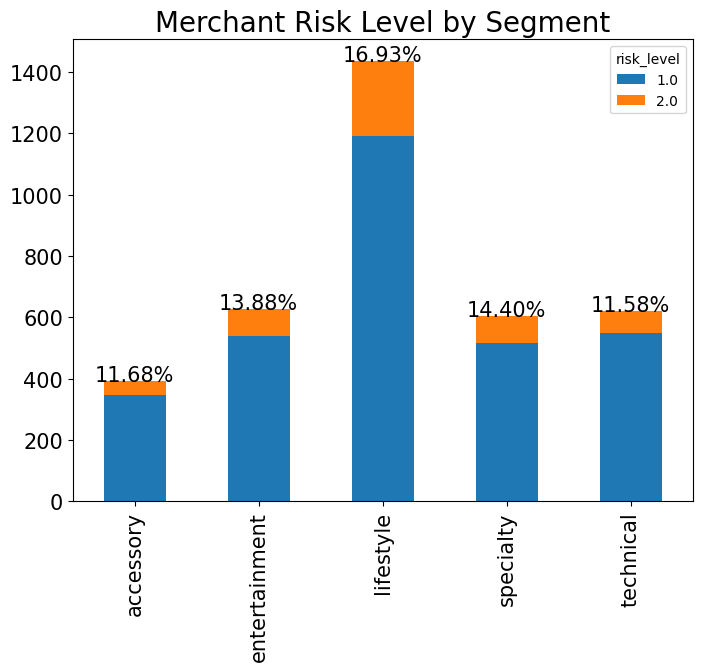

In [8]:
# draw chart
risk_by_segment_counts = merchant_risk_by_segment.groupby(['segment', 'risk_level']).size().unstack()
risk_by_segment_counts.plot(kind='bar', stacked=True, figsize=(8, 6), fontsize=15)

# label proportion of risky merchants in each segment
for i in range(len(risk_by_segment_counts)):
    total = risk_by_segment_counts.iloc[i].sum()
    risky = risk_by_segment_counts.iloc[i, 1]
    plt.text(i, total, '{:.2f}%'.format(risky / total * 100), ha='center', fontsize=15)

plt.title('Merchant Risk Level by Segment', fontsize=20)
plt.xlabel('')
plt.show()


In [9]:
# encode risk_level to safe and risky
merchant_risk_by_segment['risk_level'] = merchant_risk_by_segment['risk_level'].map({'safe': 0, 'risky': 1})

In [10]:
# check out merchant based consumer risk level
consumer_risk_level = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_prediction.parquet')

# group by merchant_abn and calculate the 'fraud' proportion inside column 'consumer_fraud_probability'
fraud_count = consumer_risk_level[consumer_risk_level['consumer_fraud_probability'] == 'fraud'].groupby('merchant_abn').size().reset_index(name='fraud_count')
total_count = consumer_risk_level.groupby('merchant_abn').size().reset_index(name='total_count')

fraud_proportion = pd.merge(fraud_count, total_count, on='merchant_abn', how='left')
fraud_proportion['fraud_proportion'] = fraud_proportion['fraud_count'] / fraud_proportion['total_count']


In [11]:
fraud_proportion

,merchant_abn,fraud_count,total_count,fraud_proportion
0,10023283211,8,3261,0.002453
1,10142254217,4,3032,0.001319
2,10206519221,12,9605,0.001249
3,10264435225,6,5026,0.001194
4,10279061213,1,555,0.001802
...,...,...,...,...
2179,99807059634,1,13,0.076923
2180,99845294286,5,795,0.006289
2181,99904689266,1,5767,0.000173
2182,99938978285,52,17443,0.002981


In [12]:
# merge merchant segment and consumer risk level
transaction_risk_by_segment = pd.merge(merchant_segment[['merchant_abn', 'segment']], fraud_proportion, on='merchant_abn', how='inner')
transaction_risk_by_segment

,merchant_abn,segment,fraud_count,total_count,fraud_proportion
0,10023283211,lifestyle,8,3261,0.002453
1,10142254217,technical,4,3032,0.001319
2,10206519221,lifestyle,12,9605,0.001249
3,10264435225,accessory,6,5026,0.001194
4,10279061213,technical,1,555,0.001802
...,...,...,...,...,...
2179,99807059634,lifestyle,1,13,0.076923
2180,99845294286,entertainment,5,795,0.006289
2181,99904689266,entertainment,1,5767,0.000173
2182,99938978285,specialty,52,17443,0.002981


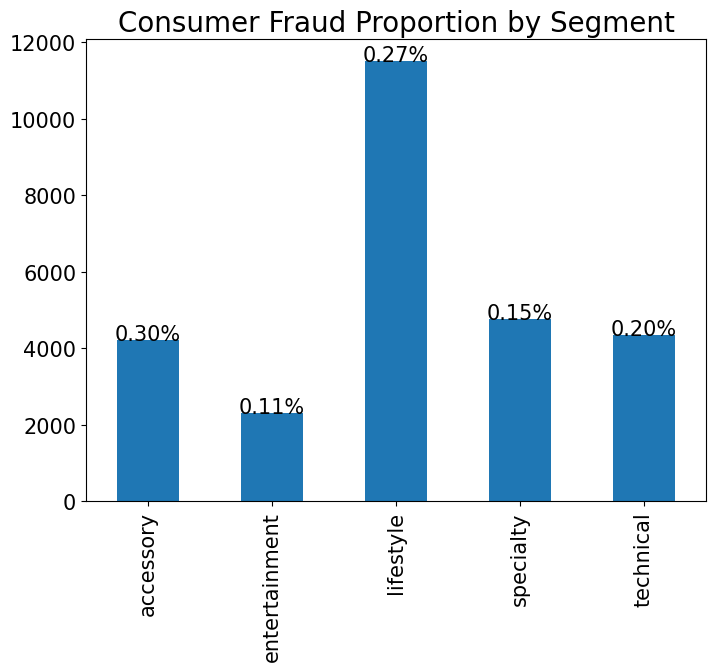

In [13]:
# count total fraud_count and total_count in each segment
total_fraud_count = transaction_risk_by_segment.groupby('segment')['fraud_count'].sum()
total_count = transaction_risk_by_segment.groupby('segment')['total_count'].sum()

# calculate fraud_proportion
fraud_proportion = total_fraud_count / total_count

# draw chart based on merchant segment including total_fraud_count and total_count for each segment, and label fraud_proportion
total_fraud_count.plot(kind='bar', figsize=(8, 6), fontsize=15)
for i in range(len(total_fraud_count)):
    plt.text(i, total_fraud_count.iloc[i], '{:.2f}%'.format(fraud_proportion.iloc[i] * 100), ha='center', fontsize=15)

plt.title('Consumer Fraud Proportion by Segment', fontsize=20)
plt.xlabel('')
plt.show()

In [14]:
fraud_proportion

segment
accessory        0.003019
entertainment    0.001086
lifestyle        0.002685
specialty        0.001546
technical        0.002046
dtype: float64

In [15]:
risk_by_segment_counts

risk_level,1.0,2.0
segment,,
accessory,348,46
entertainment,540,87
lifestyle,1192,243
specialty,517,87
technical,550,72


In [16]:
# risk_by_segment_counts's 2.0 proportion by segment
risk_by_segment_counts['proportion'] = risk_by_segment_counts[2] / (risk_by_segment_counts[1] + risk_by_segment_counts[2])

# multiply risk_by_segment_counts's 2.0 proportion by fraud_proportion
risk_by_segment_counts['multi_proportion'] = risk_by_segment_counts['proportion'] * fraud_proportion

# scale multi_proportion by 1000
risk_by_segment_counts['multi_proportion'] = risk_by_segment_counts['multi_proportion'] * 1000

risk_by_segment_counts

risk_level,1.0,2.0,proportion,multi_proportion
segment,,,,
accessory,348,46,0.116751,0.352479
entertainment,540,87,0.138756,0.150640
lifestyle,1192,243,0.169338,0.454668
specialty,517,87,0.144040,0.222698
technical,550,72,0.115756,0.236857


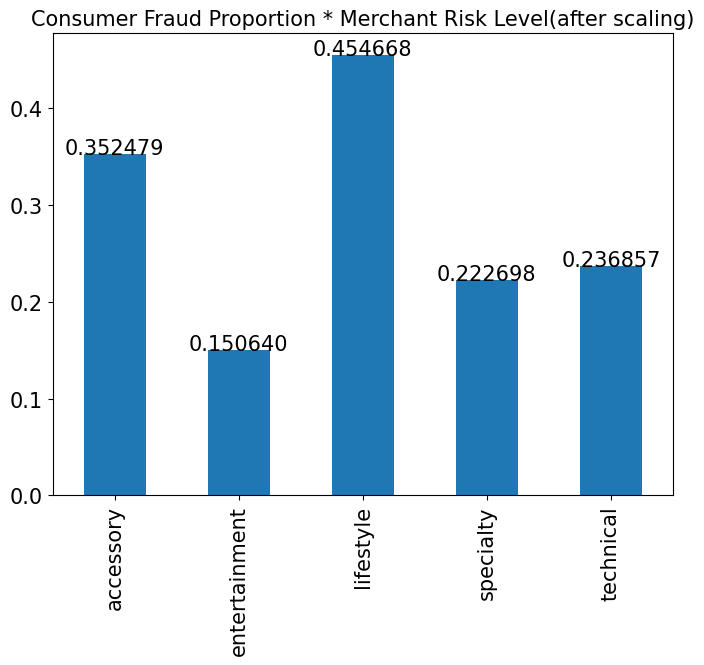

In [17]:
# draw consumer fraud proportion * merchant risk level in proportion value by segment, and label it
risk_by_segment_counts['multi_proportion'].plot(kind='bar', figsize=(8, 6), fontsize=15)
for i in range(len(risk_by_segment_counts)):
    plt.text(i, risk_by_segment_counts.iloc[i, 3], '{:.6f}'.format(risk_by_segment_counts.iloc[i, 3]), ha='center', fontsize=15)

plt.title('Consumer Fraud Proportion * Merchant Risk Level(after scaling)', fontsize=15)
plt.xlabel('')
plt.show()